## Initialization matters!

In this notebook I will show that the initialization matters: you can't just initialize each weight of a sufficiently deep neural network to a random number from a normal distribution. The neural network can not be trained in this case efficiently due to a gradient vanishing problem. The better initialization tactic is called an 'xavier initialization'.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

Define classes and functions.

In [2]:
class ANN:
  '''Artificial Neural Network class.'''
  
  def __init__(self, dims, init_type, nonlin_type):
    '''
    dims -- number of nodes of each layer.
    init_type:
      'normal' -- simple normal distribution initialization.
      'xavier' -- xavier initialization.
    
    nonlin_type: 'tanh' or 'relu' -- nonlinear function for each layer except
                                     last (it's sigmoid).
    '''
    np.random.seed(2)
    self.params = dict()
    self.L = len(dims)
    self.m = len(Y)
    self.nonlin_type = nonlin_type
    for i in range(1, self.L):
      if init_type == 'normal':
        self.params[f'W{i}'] = np.random.randn(dims[i], dims[i-1]) * 0.1
      elif init_type == 'xavier':
        self.params[f'W{i}'] = np.random.randn(dims[i], dims[i-1]) / np.sqrt(dims[i-1])
      self.params[f'b{i}'] = np.zeros((dims[i],1))
    
  def forward(self, X, Y=None):
    '''
    Forward propogation.
    '''
    self.X = X
    self.Y = Y
    self.cache = dict()
    self.cache['A0'] = X
    for i in range(1, self.L):
      self.cache[f'Z{i}'] = np.dot(self.params[f'W{i}'], self.cache[f'A{i-1}']) + self.params[f'b{i}']
      if i == self.L-1:
        self.cache[f'A{i}'] = 1 / (1 + np.exp(-self.cache[f'Z{i}']))
      else:
        if self.nonlin_type == 'tanh':
          self.cache[f'A{i}'] = np.tanh(self.cache[f'Z{i}'])
        elif self.nonlin_type == 'relu':
          self.cache[f'A{i}'] = np.maximum(self.cache[f'Z{i}'], 0)
    if Y is not None:
      self.J = -1/self.m * np.sum(np.log(self.cache[f'A{self.L-1}']) * Y + np.log(1 - self.cache[f'A{self.L-1}']) * (1 - Y))
    
  def backward(self):
    '''
    Backward propogation.
    '''
    for i in reversed(range(1, self.L)):
      if i == self.L-1:
        self.cache[f'dZ{i}'] = self.cache[f'A{i}'] - self.Y
      else:
        self.cache[f'dA{i}'] = np.dot(self.params[f'W{i+1}'].T, self.cache[f'dZ{i+1}'])
        if self.nonlin_type == 'tanh':
          self.cache[f'dZ{i}'] = self.cache[f'dA{i}'] * (1 - np.tanh(self.cache[f'A{i}'])**2)
        elif self.nonlin_type == 'relu':
          self.cache[f'dZ{i}'] = np.multiply(self.cache[f'dA{i}'], np.int64(self.cache[f'A{i}'] > 0))
      self.cache[f'dW{i}'] = 1/self.m * np.dot(self.cache[f'dZ{i}'], self.cache[f'A{i-1}'].T)
      self.cache[f'db{i}'] = 1/self.m * np.sum(self.cache[f'dZ{i}'], axis=1, keepdims=True)
  
  def predict(self, X):
    '''
    Make predictions.
    '''
    self.forward(X)
    return self.cache[f'A{self.L-1}'] > 0.5
  
  def update(self, lambd):
    '''
    Update weigths and biases.
    '''
    for key,_ in self.params.items():
      self.params[key] -= self.cache[f'd{key}'] * lambd

      
######## Helper functions ########

def plot(X, Y):
  plt.ylabel('x2')
  plt.xlabel('x1')
  plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral)
  plt.show()
  
def plot_decision_boundary(model, X, Y):
  # Set min and max values and give it some padding
  x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
  y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
  h = 0.01
  # Generate a grid of points with distance h between them
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
  # Predict the function value for the whole grid
  Z = model.predict(np.c_[xx.ravel(), yy.ravel()].T)
  Z = Z.reshape(xx.shape)
  # Plot the contour and training examples
  plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
  plt.scatter(X[0, :], X[1, :], c=Y, cmap=plt.cm.Spectral)
  plt.show()

Make data.

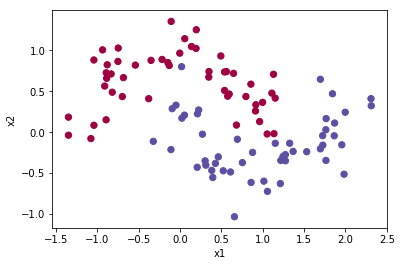

In [3]:
X, Y = make_moons(n_samples=100, noise=0.2, random_state=1)
X = X.T
plot(X, Y)

Create a deep neural network to better illustrate the point. First initialize it's weights with a simple normal distribution.

In [4]:
dims = [2, 16, 8, 8, 8, 8, 8, 8, 4, 4, 4, 2, 1]
nn0 = ANN(dims, 'normal', 'tanh')

Let's train it.

In [5]:
for epoch in range(4500 + 1):
  nn0.forward(X, Y)
  nn0.backward()
  nn0.update(0.005)
  if epoch % 500 == 0:
    print(f"Epoch {epoch}: {nn0.J}")

Epoch 0: 0.693147187559383
Epoch 500: 0.6931471875592493
Epoch 1000: 0.6931471875591152
Epoch 1500: 0.6931471875589813
Epoch 2000: 0.6931471875588473
Epoch 2500: 0.6931471875587131
Epoch 3000: 0.6931471875585793
Epoch 3500: 0.6931471875584455
Epoch 4000: 0.6931471875583114
Epoch 4500: 0.6931471875581774


As you can see, it's stucked. And a decision boundary is really sucks.

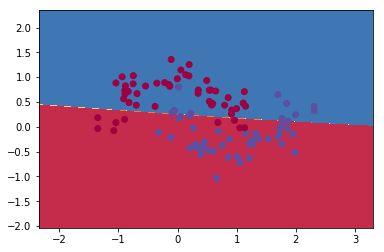

In [6]:
plot_decision_boundary(nn0, X, Y)

Now let's do the same but with a xavier initialization.

In [7]:
dims = [2, 16, 8, 8, 8, 8, 8, 8, 4, 4, 4, 2, 1]
nn1 = ANN(dims, 'xavier', 'tanh')
for epoch in range(4500 + 1):
  nn1.forward(X, Y)
  if epoch % 500 == 0:
    print(f"Epoch {epoch}: {nn1.J}")
  nn1.backward()
  nn1.update(0.005)

Epoch 0: 0.7677476062189245
Epoch 500: 0.5420571903328136
Epoch 1000: 0.43312618830366695
Epoch 1500: 0.3877959762528388
Epoch 2000: 0.337558116783168
Epoch 2500: 0.3087632021664846
Epoch 3000: 0.17554413620297055
Epoch 3500: 0.16046742181610157
Epoch 4000: 0.12065645742515368
Epoch 4500: 0.08941574906119244


As you can see now the same model can learn! The difference is only in initialization values.

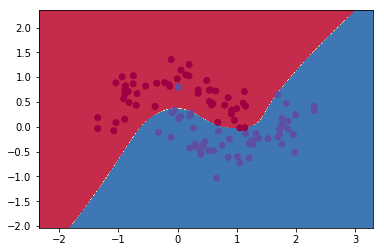

In [8]:
plot_decision_boundary(nn1, X, Y)

Now let's do the same but on model with relu activation function (I only increased the learning rate lambda).

In [9]:
dims = [2, 16, 8, 8, 8, 8, 8, 8, 4, 4, 4, 2, 1]
nn2 = ANN(dims, 'normal', 'relu')
for epoch in range(4500 + 1):
  nn2.forward(X, Y)
  nn2.backward()
  nn2.update(0.05)
  if epoch % 500 == 0:
    print(f"Epoch {epoch}: {nn2.J}")

Epoch 0: 0.6931471805483626
Epoch 500: 0.6931471805599455
Epoch 1000: 0.6931471805599453
Epoch 1500: 0.6931471805599453
Epoch 2000: 0.6931471805599453
Epoch 2500: 0.6931471805599453
Epoch 3000: 0.6931471805599453
Epoch 3500: 0.6931471805599453
Epoch 4000: 0.6931471805599453
Epoch 4500: 0.6931471805599453


Not training. What about xavier?

In [10]:
dims = [2, 16, 8, 8, 8, 8, 8, 8, 4, 4, 4, 2, 1]
nn3 = ANN(dims, 'xavier', 'relu')
for epoch in range(4500 + 1):
  nn3.forward(X, Y)
  nn3.backward()
  nn3.update(0.05)
  if epoch % 500 == 0:
    print(f"Epoch {epoch}: {nn3.J}")

Epoch 0: 0.6927945090827544
Epoch 500: 0.6891751954733587
Epoch 1000: 0.24756300168822887
Epoch 1500: 0.0935471534229221
Epoch 2000: 0.08689219446150308
Epoch 2500: 0.08548099364770119
Epoch 3000: 0.08502651976591587
Epoch 3500: 0.08487103022018558
Epoch 4000: 0.0848235542914961
Epoch 4500: 0.08479357711626274


That's now working. Actually there is a better initialization choice for a relu, it's called "he initialization", but xavier works well too.

### Auxiliary code

In [ ]:
# Check gradients.

dims = [2, 4, 2, 1]
nn0 = ANN(dims, 'normal', 'relu')
nn0.forward(X, Y)
nn0.backward()
print("======== Computed ========")
delta = 10**(-9)
for key,_ in nn0.params.items():
  arr = np.ndarray(nn0.params[key].shape)
  for i in range(len(nn0.params[key])):
    for j in range(len(nn0.params[key][i])):
      nn0_plus = ANN(dims, 'normal', 'relu')
      nn0_plus.params[key][i,j] = nn0.params[key][i,j] + delta
      nn0_plus.forward(X, Y)
      nn0_minus = ANN(dims, 'normal', 'relu')
      nn0_minus.params[key][i,j] = nn0.params[key][i,j] - delta
      nn0_minus.forward(X, Y)
      arr[i,j] = (nn0_plus.J - nn0_minus.J) / (2 * delta)
  print(f'd{key}')
  print(arr)
  print()
print()
print("======== Analytical ========")
for key,_ in nn0.params.items():
  print(f'd{key}')
  print(nn0.cache[f'd{key}'])
  print()